In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import altair as alt
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import teotil3 as teo
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part B: Compare to measured fluxes

This notebook compares output from the TEOTIL3 model with observed datasets.

## 1. Generate input files

The code below generates model input files from the "raw" data in the TEOTIL3 database.

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


In [4]:
nve_data_year = 2023
st_yr, end_yr = 2013, 2022
out_csv_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [5]:
# %%time

# # Generate model input files and save to disk
# years = range(st_yr, end_yr + 1)
# for year in tqdm(years):
#     gdf = teo.io.make_input_file(
#         year,
#         nve_data_year,
#         eng,
#         out_csv_fold=out_csv_fold,
#         nan_to_vass=True,
#         add_offshore=True,
#         order_coastal=False,  # Recommend False, excpet for comparison with TEOTIL2
#         land_to_vass=True,  # Recommend True, excpet for comparison with TEOTIL2
#     )

## 2. Run model

The code below runs the model for the period of interest. Results are merged and saved to a single CSV, so this code does not need re-running unless the model or its inputs are updated.

In [6]:
# ############################################################################
# # Set totals_from_subfracs=True below once all fractions are in the database
# ############################################################################

# # Run TEOTIL3
# years = range(st_yr, end_yr + 1)
# df_list = []
# for year in tqdm(years):
#     csv_path = os.path.join(
#         out_csv_fold,
#         f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
#     )
#     g = teo.model.run_model(
#         csv_path,
#         id_col="regine",
#         next_down_col="regine_down",
#         totals_from_subfracs=True,
#     )
#     res_df = teo.model.model_to_dataframe(
#         g, id_col="regine", next_down_col="regine_down"
#     )
#     res_df["year"] = year
#     df_list.append(res_df)
# mod_df = pd.concat(df_list, axis="rows")

# mod_csv = os.path.join(
#     eval_fold, f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"
# )
# mod_df.to_csv(mod_csv, index=False)

In [7]:
# Read saved data for speed
mod_csv = os.path.join(
    eval_fold, f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_aquaculture_din_kg,accum_aquaculture_tdp_kg,accum_aquaculture_toc_kg,accum_aquaculture_ton_kg,accum_aquaculture_totn_kg,accum_aquaculture_totp_kg,accum_aquaculture_tpp_kg,accum_glacier_ss_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.1,849.2,0.6,8131.6,198.1,229.2,3.8,3.2,2013
1,001.1A2B,001.1A2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.4,1118.4,29798.4,22.2,305633.2,7434.2,8552.6,145.1,122.9,2013
2,001.1A4D,001.1A4C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,201.7,5272.5,4.0,55828.0,1357.5,1559.2,26.5,22.5,2013
3,001.1M,001.1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,400.8,11104.0,8.1,113980.3,2751.8,3152.6,53.8,45.7,2013
4,001.21,001.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.2,117.0,0.1,1110.1,27.1,31.3,0.5,0.4,2013


## 3. Compare to measured data

### 3.1. Discharge

Since many of the nutrient fluxes in TEOTIL3 are linked to runoff, it is import the model produces sensible estimates of discharge.

#### 3.1.1. Data for all NVE stations

As a general test, the code in this section downloads all discharge data available from NVE's HydAPI within the period of interest. This is a coarse approach and there are likely lots of edge cases where the model will perform badly, but it should neverless give a broad indications of the model's performance across a range of spatial scales and geographic regions. 

In [8]:
# Define stations, parameters and time period of interest
par_ids = [1001]  # Discharge
st_dt = f"{st_yr}-01-01"
end_dt = f"{end_yr}-12-31"

In [9]:
# List all stations
stn_df = nivapy.da.get_nve_hydapi_stations()
print(len(stn_df), "stations available.")
stn_df.head()

1782 stations available.


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
0,1.15.0,Femsjø,59.13015,11.48516,298887,6559841,81,Haldenvassdraget,3001,Halden,...,NaN,NaN,NaN,NaN,79.5445,79.6849,79.8397,80.0075,80.2569,"[{'parameterName': 'Vannstand', 'parameter': 1..."
1,1.200.0,Lierelv,59.92038,11.53180,306146,6647624,134,Haldenvassdraget,3026,Aurskog-Høland,...,32.6537,34.9251,36.4982,37.9152,2.2229,2.3076,2.3381,2.3585,2.3764,"[{'parameterName': 'Vannstand', 'parameter': 1..."
2,1.41.0,Lognselva,59.80011,11.44331,300484,6634505,148,Haldenvassdraget,3026,Aurskog-Høland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannstand', 'parameter': 1..."
3,1.42.0,Øymarksjø,59.33290,11.63712,308715,6581952,109,Haldenvassdraget,3012,Aremark,...,NaN,NaN,NaN,NaN,108.7308,108.9470,109.1370,109.3253,109.5781,"[{'parameterName': 'Vannstand', 'parameter': 1..."
4,1.43.0,Aspern og Ara,59.14667,11.69273,310848,6561073,106,Haldenvassdraget,3012,Aremark,...,NaN,NaN,NaN,NaN,106.0564,106.1387,106.2884,106.4785,106.8168,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [10]:
# # Get all discharge data for period from interest from HydAPI
# df_list = []
# stn_ids = []
# for stn_id in tqdm(list(stn_df["station_id"])):
#     try:
#         df = nivapy.da.query_nve_hydapi(
#             [stn_id], par_ids, st_dt, end_dt, resolution=1440
#         )
#         df_list.append(df)
#         stn_ids.append(stn_id)
#     except:
#         pass
# obs_q_df = pd.concat(df_list, axis="rows")
# stn_df = stn_df.query("station_id in @stn_ids")

# # Calculate annual mean flows
# obs_q_df["year"] = obs_q_df["datetime"].dt.year
# obs_q_df = obs_q_df[["station_id", "year", "value"]]
# obs_q_df = obs_q_df.groupby(["station_id", "year"]).agg(["mean", "count"])
# obs_q_df.columns = obs_q_df.columns.get_level_values(1)
# obs_q_df.reset_index(inplace=True)
# obs_q_df = obs_q_df.query("count > 360")
# del obs_q_df["count"]
# obs_q_df.rename({"mean": "obs_q_m3ps"}, axis="columns", inplace=True)

# # Join station details
# obs_q_df = pd.merge(
#     obs_q_df,
#     stn_df[
#         [
#             "station_id",
#             "station_name",
#             "latitude",
#             "longitude",
#             "drainageBasinArea",
#             "regineNo",
#             "specificDischarge",
#         ]
#     ],
#     how="left",
#     on="station_id",
# )
# nve_csv = os.path.join(eval_fold, f"nve_hydapi_discharge_{st_yr}-{end_yr}.csv")
# obs_q_df.to_csv(nve_csv, index=False)

In [11]:
# Read saved data for speed
nve_csv = os.path.join(eval_fold, f"nve_hydapi_discharge_{st_yr}-{end_yr}.csv")
obs_q_df = pd.read_csv(nve_csv)
obs_q_df.rename({"regineNo": "regine"}, axis="columns", inplace=True)

# Remove stations that are not approptiate to compare
#  74.109.0 - NVE values are really extreme (>1E6 m3/s, which is bigger than the Amazon!)
#  2.1119.0 - Regine is part of Glomma main stem, but station is on a small tributary
#  16.154.0 - Regine is part of Skienselva main stem, but station is on a small tributary
#  2.1225.0 - Regine is part of Vorma/Lågen main stem, but station is on a small tributary
#  156.49.0 - Major dam (i.e. regulated)
#  Sites named 'Total Q...' are heavily regulated
excl_list = ["2.1119.0", "16.154.0", "2.1225.0", "156.49.0", "74.109.0"]
obs_q_df = obs_q_df.query("station_id not in @excl_list")
obs_q_df = obs_q_df[~obs_q_df["station_name"].str.startswith("Total Q")]

obs_q_df.head()

,station_id,year,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,regine,specificDischarge
0,1.200.0,2013,1.743028,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
1,1.200.0,2014,2.742378,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
2,1.200.0,2015,2.013650,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
3,1.200.0,2016,1.431752,Lierelv,59.92038,11.5318,132.93,001.K41,14.08
4,1.200.0,2017,1.547375,Lierelv,59.92038,11.5318,132.93,001.K41,14.08


Number of unique stations with data: 487
Number of annual flow estimates to compare: 4298


,regine,year,accum_q_m3/s,station_id,obs_q_m3ps,station_name,latitude,longitude,drainageBasinArea,specificDischarge
0,002.DC3BZ,2013,1.484752,2.323.0,0.892759,Fura,60.88483,11.32496,36.41,11.28
1,002.DFB6C,2013,1.643225,2.415.0,2.262316,Espedalsvatn,61.43769,9.49436,94.42,18.50
2,002.LG,2013,4.695963,2.479.0,4.181078,Li bru,62.00998,10.00033,156.86,23.77
3,002.MG,2013,1.522146,2.592.0,0.842681,Fokstua,62.11198,9.28987,26.54,19.94
4,006.G2C,2013,0.145098,6.71.0,0.149332,Sinnerdammen,60.17265,10.49514,7.63,20.36


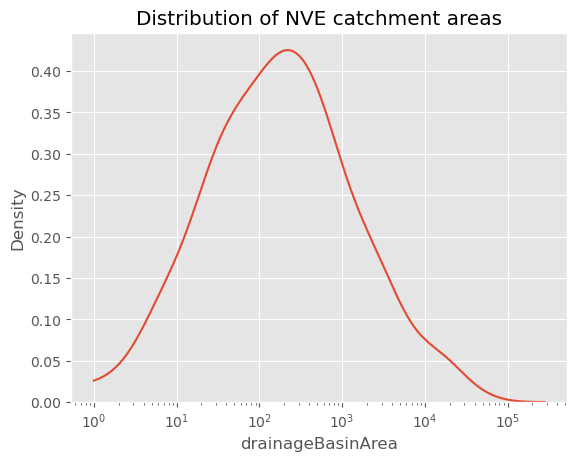

In [12]:
# Join modelled and observed data series
comp_df = pd.merge(
    mod_df[["regine", "year", "accum_q_m3/s"]],
    obs_q_df,
    how="inner",
    on=["regine", "year"],
)

comp_stn_df = comp_df[
    [
        "station_id",
        "station_name",
        "regine",
        "longitude",
        "latitude",
        "drainageBasinArea",
    ]
].drop_duplicates()

print("Number of unique stations with data:", len(comp_df["station_id"].unique()))
print("Number of annual flow estimates to compare:", len(comp_df))
ax = sn.kdeplot(comp_stn_df, x="drainageBasinArea", clip=(0, None), log_scale=True)
ax.set_title("Distribution of NVE catchment areas")
comp_df.head()

So, we have nearly 500 stations and more than 4000 annual discharge estimates in the period from 2013 to 2022. Based on the NVE data, most of these stations are monitoring small to medium catchments, typically a few hundred km2 in size. I believe these catchments will provide a good test for TEOTIL3, because simulating smaller catchments is likely to be most challenging for the model. This is because TEOTIL3 uses input data provided by NVE at vassdragsområde level (i.e. very large catchments), and I therefore expect TEOTIL3 to perform well for these (at least, as well as the NVE models). However, it may not perform so well at local scales, due to the model's simple approach for spatially distributing flows.

In [13]:
# Plot with ALtair
scatter = (
    alt.Chart(comp_df)
    .mark_circle(size=60)
    .encode(
        x=alt.X("obs_q_m3ps", title="Observed (m3/s)"),
        y=alt.Y("accum_q_m3/s", title="TEOTIL3 (m3/s)"),
        tooltip=["station_id", "station_name", "regine", "year"],
    )
    .properties(width=600, height=400)
)

line = (
    alt.Chart(comp_df).mark_line(color="black").encode(x="obs_q_m3ps", y="obs_q_m3ps")
)

chart = alt.layer(scatter, line).interactive()

chart

alt.LayerChart(...)

In [14]:
# Fit simple OLS model
model = smf.ols(formula="Q('accum_q_m3/s') ~ obs_q_m3ps", data=comp_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Q('accum_q_m3/s')   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 9.742e+04
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:19:41   Log-Likelihood:                -17649.
No. Observations:                4298   AIC:                         3.530e+04
Df Residuals:                    4296   BIC:                         3.531e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7124      0.241     11.246      0.0

On the whole, I am pleased with this result. With the exception of a small number of heavily regulated catchments, the model does an excellent job of predicting annual flows for small to medium catchments, as well as much larger ones. There is no obvious systematic bias and the fitted slope of 0.999 is far better than I had hoped!

**Note:** This is not an entirely independent check of TEOTIL3, as I assume a lot of the measured data is used by NVE when calibrating their original hydrology model. However, it is independent in the sense of comparing modelled against "real" measured data, and TEOTIL3 has never “seen” data from any of these catchments before.

#### 3.1.2. The JOVA catchments

NIBIO have expressed concerns that the new TEOTIL model overestimates runoff for the JOVA catchments (see e-mail from Sigrun received 13.11.2023 at 12.44). There is no obvious bias in the plot above (which compares against the NVE data). The code below explore the data provided by Sigrun.

In [15]:
# Read NIBIO site details
nibio_csv = r"../../data/nibio_jova_runoff.csv"
nibio_df = pd.read_csv(nibio_csv)

# Assign to regines
nibio_df = nivapy.spatial.utm_to_wgs84_dd(
    nibio_df, zone="utm_zone", east="utm_east", north="utm_north"
)
reg_gdf = teo.io.get_regine_geodataframe(eng, 2022)
nibio_df = nivapy.spatial.identify_point_in_polygon(
    nibio_df,
    reg_gdf,
    pt_col="station_code",
    poly_col="regine",
    lat_col="lat",
    lon_col="lon",
)

# Join TEOTIL mean runoff for 1991-2020
nibio_df = pd.merge(
    nibio_df, reg_gdf[["regine", "runoff_mm/yr"]], how="left", on="regine"
)
nibio_df

,station_code,station_name,utm_north,utm_east,utm_zone,nibio_runoff_mm,lat,lon,regine,runoff_mm/yr
0,hot,Hotranelva,7062146,607425,32,707,63.670712,11.171089,126.4Z,788
1,nau,Naurstadbekken,7473876,751195,32,1082,67.275268,14.834062,164.4,793
2,vol,Volbubekken,6776162,503141,32,288,61.120063,9.058295,012.LB2,349
3,tim,Timebekken,6514206,308669,32,912,58.725508,5.695156,028.4D,1233
4,ska,Skas-Heigre,6527035,303696,32,687,58.838293,5.598187,028.AZ,952
5,kol,Kolstadbekken,6750840,598961,32,366,60.880387,10.823014,002.DC72,494
6,mør,Mørdrebekken,6667561,633103,32,318,60.123343,11.395586,002.D6,335
7,sku,Skuterudbekken,6616575,603054,32,552,59.674433,10.829790,005.3B,460
8,vas,Vasshaglona,6466701,468651,32,1039,58.340107,8.464553,019.2C,1177


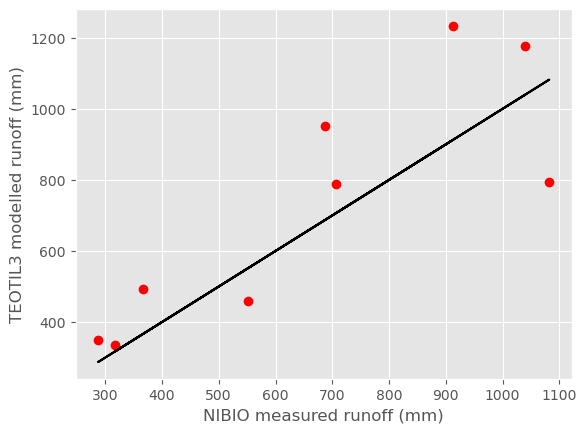

In [16]:
# Plot
plt.plot(nibio_df["nibio_runoff_mm"], nibio_df["runoff_mm/yr"], "ro")
plt.plot(
    nibio_df["nibio_runoff_mm"], nibio_df["nibio_runoff_mm"], "k-", label="1:1 line"
)
plt.xlabel("NIBIO measured runoff (mm)")
plt.ylabel("TEOTIL3 modelled runoff (mm)");

The fit is not as good as before, but still not bad. There are three main outliers: two sites where TEOTIL seems to substantially overestimate runoff ('tim' and 'ska') and one where runoff is underestimated ('nau'). To investigate, I will try the following:

 1. First, attempt to get measured daily values for the NIBIO catchments via HydAPI (this is done by using NVE Atlas to find NVE stations near to the NIBIO sites)
 
 2. If raw data are not available, aggregated values can sometimes be found in Appendix 3 of [this](https://publikasjoner.nve.no/rapport/2022/rapport2022_36.pdf) report (page 64 onwards).

In [17]:
# Check if raw data are available from NVE
comp_stn_nve = "28.11.0"
comp_stn_nib = "tim"

comp_stn_df = stn_df.query("station_id == @comp_stn_nve")[
    [
        "station_id",
        "station_name",
        "drainageBasinArea",
        "regineNo",
        "specificDischarge",
    ]
]
comp_stn_df

,station_id,station_name,drainageBasinArea,regineNo,specificDischarge
1188,28.11.0,Lye 2,1.67,028.4D,44.94


NVE mean measured runoff: NVE measured annual    1346.757342
dtype: float64


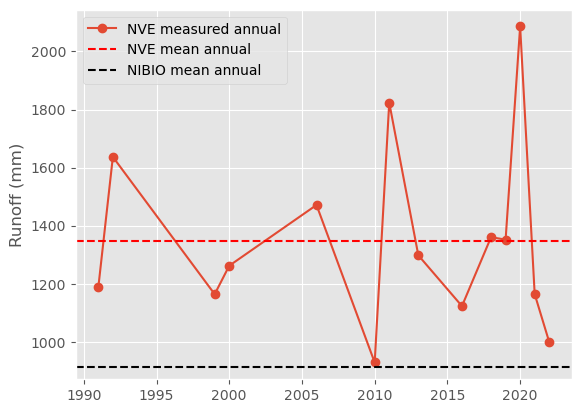

In [18]:
# Compare measured data from NVE versus NIBIO
comp_stn_area = comp_stn_df["drainageBasinArea"].iloc[0]
nve_stn_df = nivapy.da.query_nve_hydapi(
    [comp_stn_nve], [1001], "1990-01-01", f"{end_yr}-12-31", resolution=1440
)[["datetime", "value"]].set_index("datetime")
nve_stn_df["runoff_mm"] = (
    nve_stn_df["value"] * 60 * 60 * 24 * 1000 / (comp_stn_area * 1e6)
)
nve_stn_df = (
    nve_stn_df.resample("A")
    .agg(["sum", "count"])["runoff_mm"]
    .query("count > 360")[["sum"]]
)
nve_stn_df.index = nve_stn_df.index.year
nve_stn_df.columns = ["NVE measured annual"]

nibio_stn_ro = nibio_df.query("station_code == @comp_stn_nib")["nibio_runoff_mm"].iloc[
    0
]

print("NVE mean measured runoff:", nve_stn_df.mean())
# Plot
ax = nve_stn_df.plot(marker="o")
ax.axhline(
    y=nve_stn_df["NVE measured annual"].mean(),
    color="r",
    linestyle="--",
    label="NVE mean annual",
)
ax.axhline(y=nibio_stn_ro, color="k", linestyle="--", label="NIBIO mean annual")
ax.legend(loc="best")
ax.set_ylabel("Runoff (mm)")
ax.set_xlabel("");

The plot above suggests that, at site 'tim', the NIBIO discharge monitoring significantly underestimates flows compared to NVE's monitoring. I have no way of knowing which series is better, but for TEOTIL3 it is necessary to use the NVE data as no other organisation has a comprehensive national monitoring network.

After further investigation, I am quite confident that differences in runoff between TEOTIL3's estimates and NIBIO's JOVA data are due to differences between NVE's monitoring and NIBIO's monitoring within the same catchments (see e-mail sent to Sigrun 15.11.2023 at 11.24). This may eventually require further investigation, but for now I do not see any strong reasons to adjust/correct runoff estimates in TEOTIL3. 

#### 3.1.3. RID stations

The RID stations are all on big rivers with good long-term monitoring - especially for the 11 "main" rivers.

In [19]:
# Get RID stations
stn_xls = r"/home/jovyan/projects/rid/data/RID_Sites_List.xlsx"
stn_df = pd.read_excel(stn_xls, sheet_name="RID_11")

# Assign to regines
reg_gdf = teo.io.get_regine_geodataframe(eng, end_yr)
stn_df = nivapy.spatial.identify_point_in_polygon(
    stn_df,
    reg_gdf,
    pt_col="station_id",
    poly_col="regine",
    lat_col="lat",
    lon_col="lon",
)
stn_df

,station_id,station_code,station_name,rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone,regine
0,29615,VESENUM,Numedalslågen,rid_11,SKAGERAK,R,015.A1,59.086000,10.070000,6551828.42,561347.37,32,015.A1
1,29821,HOREVOS,Vosso(Bolstadelvi),rid_11,NORTH SEA,R,062.C1,60.647000,6.112000,6726970.00,342124.00,32,062.C11
2,29783,ROGEORR,Orreelva,rid_11,NORTH SEA,R,028.4A,58.731000,5.529000,6512861.00,646406.00,31,028.4A
3,29613,TELESKI,Skienselva,rid_11,SKAGERAK,R,016.A221,59.199000,9.611000,6562920.00,534741.00,32,016.A221
4,29614,VAGEOTR,Otra,rid_11,SKAGERAK,R,021.A11,58.187000,7.954000,6450006.00,438495.00,32,021.A11
5,29782,NOREVEF,Vefsna,rid_11,NORWEGIAN SEA2,R,151.A4,65.749000,13.239000,7293064.00,419297.00,33,151.A4
6,36225,OSLEALN,Alna,rid_11,SKAGERAK,R,006.2A0,59.905091,10.791359,6642144.00,600213.00,32,006.2A0
7,29617,ØSTEGLO,Glomma ved Sarpsfoss,rid_11,SKAGERAK,R,002.A51,59.279802,11.134111,6573156.00,621600.00,32,002.A51
8,29779,FINEALT,Altaelva,rid_11,LOFOTEN-BARENTS SEA,R,212.A0,69.900992,23.286977,7759686.00,586586.00,34,212.A0
9,29612,BUSEDRA,Drammenselva,rid_11,SKAGERAK,R,012.A3,59.753995,10.008990,6624446.00,556695.00,32,012.A3


In [20]:
# Get observed flow and chem
obs_csv = r"/home/jovyan/shared/common/elveovervakingsprogrammet/results/measured_loads/loads_and_flows_rid_20_1990-2022.csv"
obs_df = pd.read_csv(obs_csv)

# Get cols of interest
id_cols = ["station_id", "year"]
q_pars = ["mean_q_1000m3/day"]
chem_pars = ["NO3-N", "NH4-N", "TOTN", "PO4-P", "TOTP", "TOC", "SPM"]
cols = (
    id_cols
    + q_pars
    + [f"{i}_tonnes" for i in chem_pars]
    + [f"{i}_Est" for i in chem_pars]
)
obs_df = obs_df[cols]

# Period of interest
obs_df = obs_df.query("@st_yr <= year <= @end_yr")

# Remove statistical estimates
for par in chem_pars:
    obs_df[f"{par}_tonnes"] = obs_df[f"{par}_tonnes"].where(obs_df[f"{par}_Est"] == 0)
    del obs_df[f"{par}_Est"]
obs_df = obs_df.melt(id_vars=id_cols).dropna()

obs_df.head()

,station_id,year,variable,value
0,30019,2013,mean_q_1000m3/day,1091.548794
1,30019,2014,mean_q_1000m3/day,1703.042338
2,30019,2015,mean_q_1000m3/day,1197.751088
3,30019,2016,mean_q_1000m3/day,918.154463
4,30019,2017,mean_q_1000m3/day,1130.149148


In [21]:
# Filter to stations with observed data
stn_list = list(obs_df["station_id"].unique())
stn_df = stn_df.query("station_id in @stn_list")

# Get model results
df_list = []
for idx, row in stn_df.iterrows():
    reg_id = row["regine"]
    stn_res_df = mod_df.query("regine == @reg_id").copy()
    stn_res_df["mean_q_1000m3/day"] = stn_res_df["accum_q_m3/s"] * 60 * 60 * 24 / 1000
    stn_res_df["station_id"] = row["station_id"]
    stn_res_df = stn_res_df[["station_id", "year", "mean_q_1000m3/day"]].melt(
        id_vars=id_cols
    )
    df_list.append(stn_res_df)
rid_mod_df = pd.concat(df_list, axis="rows")

comp_df = pd.merge(
    rid_mod_df,
    obs_df,
    how="left",
    on=["station_id", "year", "variable"],
    suffixes=("_mod", "_obs"),
)
comp_df.head()

,station_id,year,variable,value_mod,value_obs
0,29615,2013,mean_q_1000m3/day,11031.974928,10333.440973
1,29615,2014,mean_q_1000m3/day,13013.448941,12031.768906
2,29615,2015,mean_q_1000m3/day,11414.425046,11285.844393
3,29615,2016,mean_q_1000m3/day,8644.442429,9675.176356
4,29615,2017,mean_q_1000m3/day,8706.971578,10670.055879


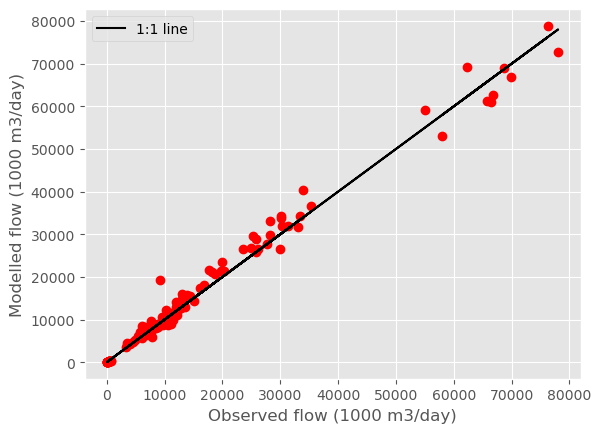

In [22]:
# Scatterplot
plt.plot(comp_df["value_obs"], comp_df["value_mod"], "ro")
plt.plot(comp_df["value_obs"], comp_df["value_obs"], "k-", label="1:1 line")
plt.xlabel("Observed flow (1000 m3/day)")
plt.ylabel("Modelled flow (1000 m3/day)")
plt.legend(loc="best")

In [23]:
# Convert to long
comp_df = comp_df.melt(id_vars=["station_id", "year", "variable"], var_name="model")
comp_df["model"] = comp_df["model"].str.replace("value_", "")
comp_df.head()

,station_id,year,variable,model,value
0,29615,2013,mean_q_1000m3/day,mod,11031.974928
1,29615,2014,mean_q_1000m3/day,mod,13013.448941
2,29615,2015,mean_q_1000m3/day,mod,11414.425046
3,29615,2016,mean_q_1000m3/day,mod,8644.442429
4,29615,2017,mean_q_1000m3/day,mod,8706.971578


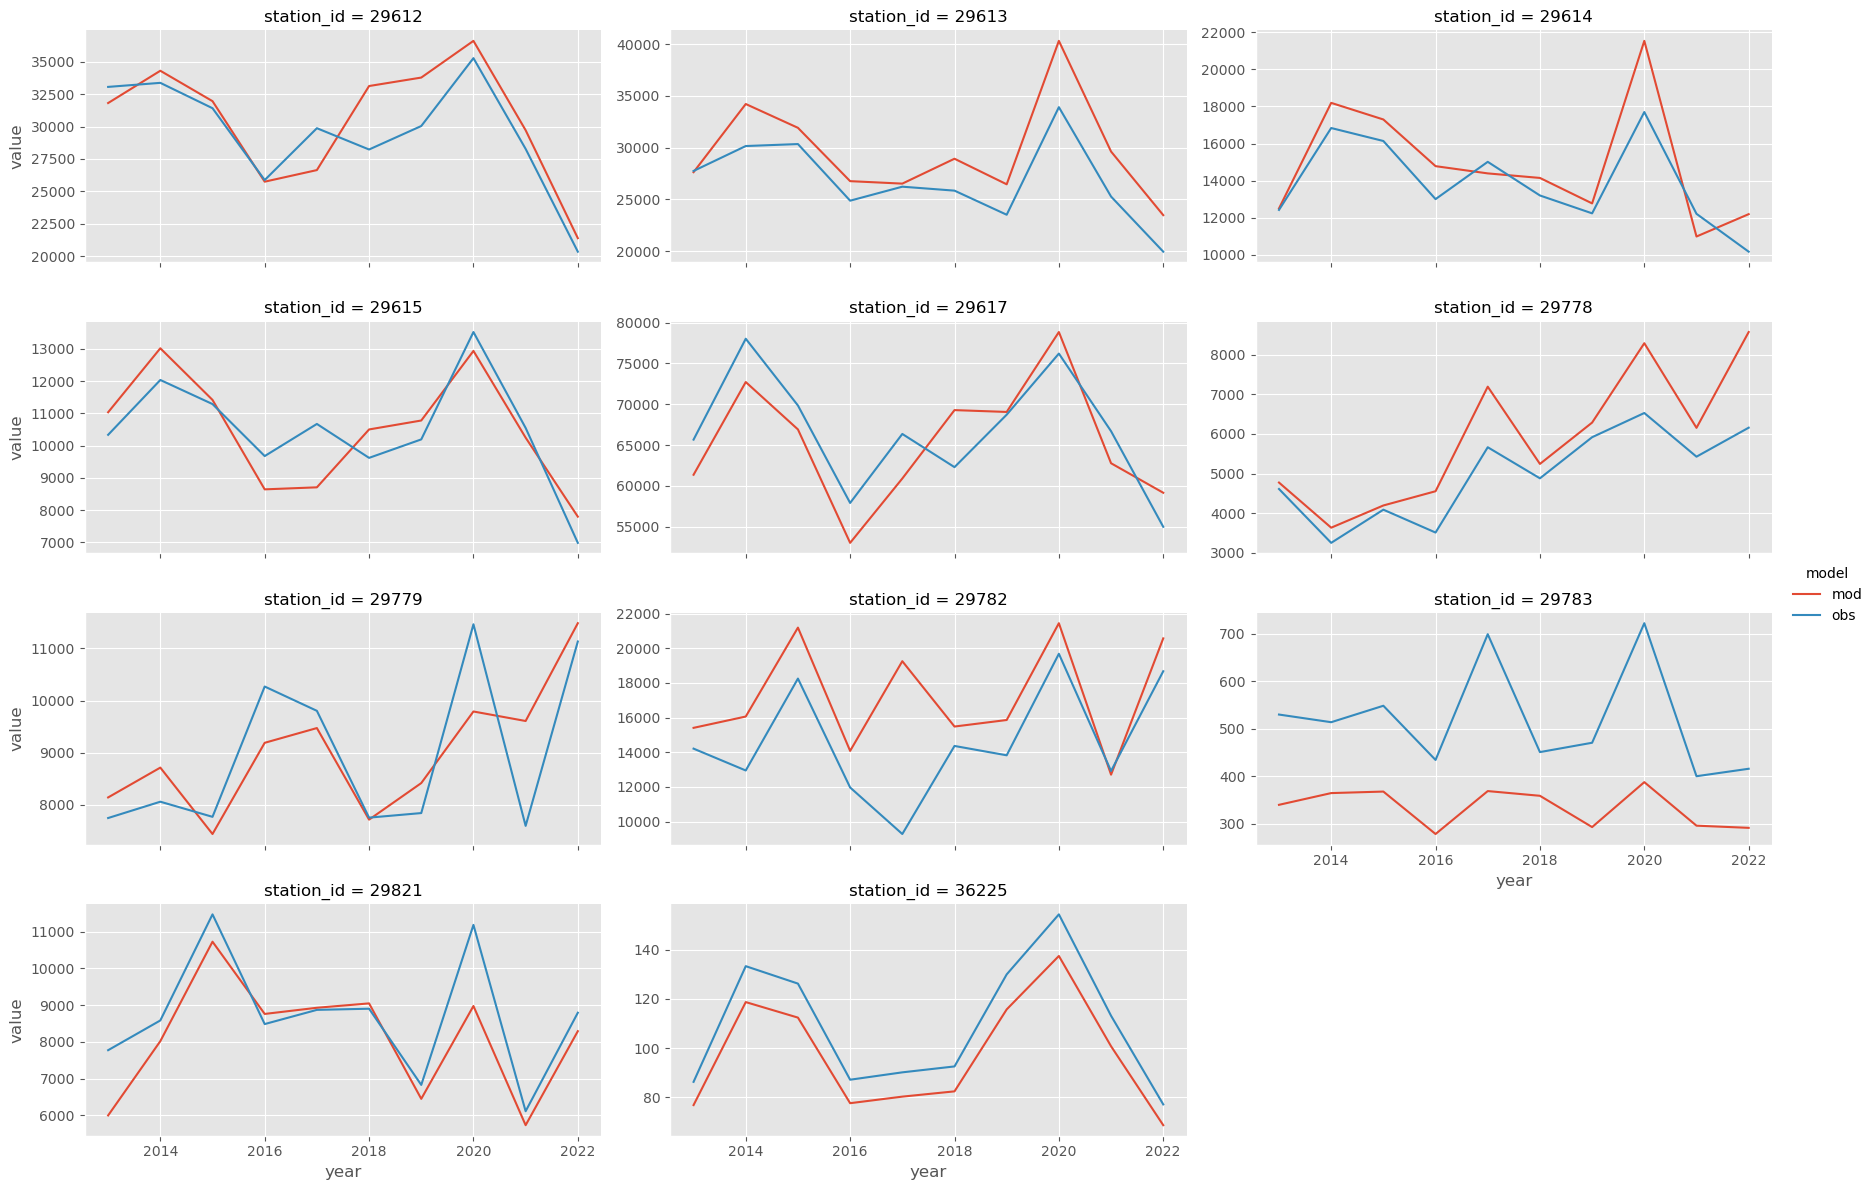

In [24]:
# Time series plots
sn.relplot(
    comp_df,
    x="year",
    y="value",
    hue="model",
    col="station_id",
    col_wrap=3,
    height=3,
    aspect=2,
    kind="line",
    facet_kws={"sharey": False},
)

In general TEOTIL3 performs well. The only station where modelled discharges are substantially different to those actually measured is 29783 (Orreelva in Rogaland). However, in the RID programme, "observed" series for this station are actually area-scaled from a neighbouring catchment (Haugland on Håånaelva), which is some distance to the south and considerably larger and more mountainous (whereas Orreelva is relatively flat). I therefore suspect TEOTIL3's estimates might be as good or better than the "observed" estimates for this site (which are actually observed somewhere else).